# Sebastian Petrik - Abstractive summarization - Data preparation and preprocessing

Datasets preprocessing, train-validation-test split, output as prepared frame with special tokens, ready for tokenization and training / inference / evaluation.

## Setup

In [1]:
!pip install openpyxl contractions --quiet

In [2]:
import os
print(os.environ.get('KAGGLE_CONTAINER_NAME')) # check if kaggle

kaggle_k7I2xo2TUDU16eXONm2JwdsojWqwWcBiWi0wq6VYXY-122793416-webtier


In [3]:
import pkg_resources
sorted(list(filter(
    lambda x: x[0] in ['numpy', 'pandas', 'tensorflow', 'tensorflow-text', 'keras', 'tensorflow-estimator', 'tensorflow-datasets', 'contractions'],
    [(i.key, i.version) for i in pkg_resources.working_set]
)))

[('keras', '2.11.0'),
 ('numpy', '1.21.6'),
 ('pandas', '1.3.5'),
 ('tensorflow', '2.11.0'),
 ('tensorflow-datasets', '4.8.2'),
 ('tensorflow-estimator', '2.11.0'),
 ('tensorflow-text', '2.11.0')]

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import operator as op
import spacy
import contractions

## Data loading

In [5]:
# show available data
!ls ../input
!ls ../input/inshorts-news-data
!ls ../input/news-summarization

inshorts-news-data  news-summarization
'Inshorts Cleaned Data.xlsx'
data.csv


In [6]:
# Inshorts XLS dataset
inshorts_raw = pd.read_excel("../input/inshorts-news-data/Inshorts Cleaned Data.xlsx",engine = 'openpyxl')
inshorts_raw.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
inshorts_raw

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...
...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the..."
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...


In [7]:
# combined 3 datasets 4GB
news_sum_combined = pd.read_csv('../input/news-summarization/data.csv')
news_sum_combined.drop(columns=news_sum_combined.columns[0], axis=1, inplace=True) # drop index col
news_sum_combined

,ID,Content,Summary,Dataset
0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail
...,...,...,...,...
870516,5d28cab74ffb4ea584cbb857d64a72a2157bf19f,The state of Oregon is ready to throw in the t...,Oregon is the only one of 16 states that has f...,CNN/Daily Mail
870517,6f3e12375fc400cf9dc3ad77b8191226e740e293,"MADRID, Spain (CNN) -- A 92-year-old woman wit...","Two women, both from Uruguay, arrested after a...",CNN/Daily Mail
870518,NaN,A day after a 40-year-old man miraculously sur...,– Rescuers in Niagara Falls still haven't foun...,Multi-News
870519,9af32ebbdd03e1d543d5493e93b4ac8c8e489851,"By . Deni Kirkova . PUBLISHED: . 09:27 EST, 23...","Women browse, evaluate and shop through an onl...",CNN/Daily Mail


## Preprocessing

In [8]:
class Preprocessor:
    
    def __init__(self, dot_token_enabled=True):
        self.dot_token_enabled = dot_token_enabled
    
    # Text cleanup
    def clean_text(self, text: str):

        # lowercase
        text = str(text).lower()

        # remove &-escaped characters
        text = re.sub(r"&.[1-9]+;"," ", str(text))

        # remove escaped characters
        text=re.sub("(\\t)", ' ', str(text))
        text=re.sub("(\\r)", ' ', str(text))
        text=re.sub("(\\n)", ' ', str(text))

        # remove double characters
        text=re.sub("(__+)", ' ', str(text))  #remove _ if it occurs more than one time consecutively
        text=re.sub("(--+)", ' ', str(text))   #remove - if it occurs more than one time consecutively
        text=re.sub("(~~+)", ' ', str(text))   #remove ~ if it occurs more than one time consecutively
        text=re.sub("(\+\++)", ' ', str(text))  #remove + if it occurs more than one time consecutively
        text=re.sub("(\.\.+)", ' ', str(text))  #remove . if it occurs more than one time consecutively
        
        # fix contractions to base form
        text = contractions.fix(text)

        #remove special tokens <>()|&©ø"',;?~*!
        text=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

        # CNN mail data cleanup
        text=re.sub("(mailto:)", ' ', str(text)) #remove mailto:
        text=re.sub(r"(\\x9\d)", ' ', str(text)) #remove \x9* in text
        text=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)) #replace INC nums to INC_NUM
        text=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)) #replace CM# and CHG# to CM_NUM

        # url replacement into base form
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
            repl_url = url.group(3)
            text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(text))
        except:
            pass


        # handle dot at the end of words
        if self.dot_token_enabled:
            text=re.sub("(\.\s+)", ' . ', str(text))
        else:
            text=re.sub("(\.\s+)", ' ', str(text)) # or completely remove
        
        text=re.sub("(\-\s+)", ' ', str(text)) #remove - at end of words(not between)
        text=re.sub("(\:\s+)", ' ', str(text)) #remove : at end of words(not between)

        #remove multiple spaces
        text=re.sub("(\s+)",' ',str(text))

        # apply lowercase again
        text = text.lower().strip()
        
        # remove trailing dot, we will apply end of sequence anyway
        text = re.sub("(\.)$", '', str(text)).strip()

        return text

    def apply_special_tokens(self, text):
        text = str(text).strip()
        text = "<sos> " + str(text).strip() + " <eos>"
        
        if self.dot_token_enabled:
            text = text.replace(".", "<dot>")
        
        return text

    def remove_special_tokens(self, text):
        text = text.lower()
        text = text.replace("<sos>", "").replace("<eos>", "")
        text = text.replace("<unk>", "##")
        text = text.replace("<dot>", ". ") # normal syntax with dot at end
        text = text.strip()
        return text

    def plot_approx_lengths(self, df: pd.DataFrame):
        sns.displot(df['article_len_approx']), sns.displot(df['summary_len_approx'])

    # preprocess sentence dataframe from raw format - clean, apply sos/eos tokens
    # - removes articles with length outside bounds
    def preprocess_frame(self, df: pd.DataFrame, article_len_range, summary_len_range):
        
        print("Preprocessing frame...")

        # apply text cleaning
        df['article'] = df['article'].apply(self.clean_text)
        df['summary'] = df['summary'].apply(self.clean_text)

        # apply special tokens
        df['article'] = df['article'].apply(self.apply_special_tokens)
        df['summary'] = df['summary'].apply(self.apply_special_tokens)

        # simple text length approximation for analysis
        df['article_len_approx'] = df['article'].apply(lambda x: op.countOf(x, ' '))
        df['summary_len_approx'] = df['summary'].apply(lambda x: op.countOf(x, ' '))

        # remove longer than set length
        article_min, article_max = article_len_range
        summary_min, summary_max = summary_len_range
        
        df = df[
            (df['article_len_approx'] <= article_max) &
            (df['article_len_approx'] >= article_min) &
            (df['summary_len_approx'] <= summary_max) &
            (df['summary_len_approx'] >= summary_min)
        ]

        # print plots
        self.plot_approx_lengths(df)

        return df
    
preprocessor = Preprocessor(dot_token_enabled=False)

# Test
preprocessor.clean_text("  This text (my text ) isn't ]] very - clean.  it WOULd'Ve been betteR? if, it was ok  ")

'this text my text is not very clean it would have been better if it was ok'

In [9]:
preprocessor.apply_special_tokens(preprocessor.clean_text(inshorts_raw.iloc[100]['Short']))

'<sos> indian spinner ravichandran ashwin has broken the record for most wickets in a single test season taking his 79th this season during the dharamsala test against australia on saturday ashwin went past south african pacer dale steyn who had claimed 78 wickets in 12 tests in 2007-08 ashwin has taken seven five-wicket hauls this season in 13 matches <eos>'

## Inshorts dataset

Preprocessing frame...
       article_len_approx  summary_len_approx
count        55098.000000        55098.000000
mean            60.144561            9.474046
std              2.694679            1.620789
min             41.000000            4.000000
25%             59.000000            8.000000
50%             61.000000            9.000000
75%             62.000000           11.000000
max             70.000000           16.000000


,summary,article,article_len_approx,summary_len_approx
0,<sos> 4 ex-bank officials booked for cheating ...,<sos> the cbi on saturday booked four former o...,61,11
1,<sos> supreme court to go paperless in 6 month...,<sos> chief justice js khehar has said the sup...,59,10
2,<sos> at least 3 killed 30 injured in blast in...,<sos> at least three people were killed includ...,61,12
3,<sos> why has reliance been barred from tradin...,<sos> mukesh ambani-led reliance industries ri...,61,10
4,<sos> was stopped from entering my own studio ...,<sos> tv news anchor arnab goswami has said he...,61,12
...,...,...,...,...
55099,<sos> sensex loses 400 points to hit 52-week l...,<sos> tracking weak cues from the asian market...,62,9
55100,<sos> china to inject $91 bn into the money ma...,<sos> amid growing concerns about china s econ...,62,10
55101,<sos> ghulam ali set to make acting debut in b...,<sos> pakistani ghazal singer ghulam ali will ...,61,10
55102,<sos> is acknowledges death of jihadi john rep...,<sos> the islamic state is has acknowledged th...,61,8


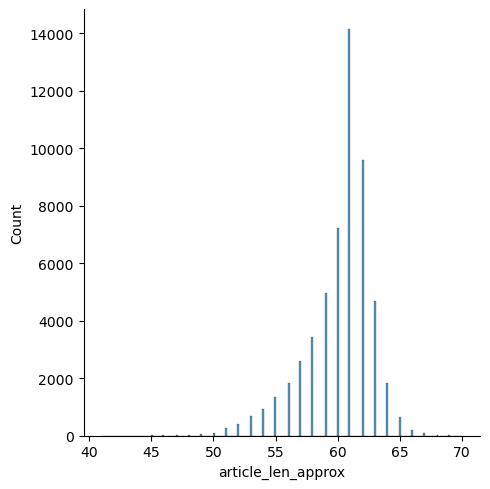

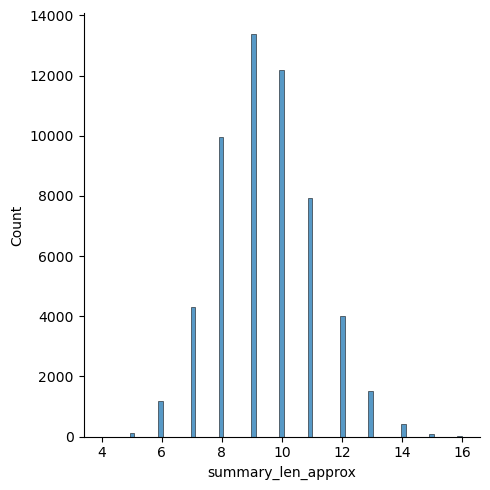

In [10]:
df_inshorts = preprocessor.preprocess_frame(
        inshorts_raw.rename({"Short": "article", "Headline": "summary"}, axis=1).reset_index(drop=True),
        (10, 70),
        (3, 16)
)
print(df_inshorts.describe())
df_inshorts

News sum available datasets: Dataset
CNN/Daily Mail    587594
Multi-News         56216
XSum              226711
Name: Dataset, dtype: int64
Preparing xsum ...
Preprocessing frame...
       article_len_approx  summary_len_approx
count       113521.000000       113521.000000
mean           175.535963           21.388880
std             75.622673            4.627048
min             10.000000            3.000000
25%            111.000000           18.000000
50%            181.000000           21.000000
75%            241.000000           25.000000
max            300.000000           40.000000


,ID,article,summary,Dataset,article_len_approx,summary_len_approx
1,36475048,<sos> 7 june 2016 last updated at 20:23 bst to...,<sos> terry butcher has been recalling alan br...,XSum,85,22
2,35586320,<sos> storms desmond eva frank and gertrude al...,<sos> borders councillors have been told the f...,XSum,133,19
7,27262382,<sos> thomas cook airlines will operate a week...,<sos> an airline has announced plans to introd...,XSum,240,17
9,34528727,<sos> roy hodgson s side are in pot one with w...,<sos> england wales and northern ireland canno...,XSum,157,29
12,14131354,<sos> mansfield district council debated the £...,<sos> plans for a major development of houses ...,XSum,265,18
...,...,...,...,...,...,...
226702,29718966,<sos> the man identified as robert kelvin elli...,<sos> the indonesian wife of a briton found wi...,XSum,207,28
226705,32071575,<sos> the 2000 olympic super-heavyweight champ...,<sos> audley harrison has retired from boxing ...,XSum,229,21
226706,15653768,<sos> the deal will begin in january and means...,<sos> microsoft yahoo and aol have announced a...,XSum,195,17
226708,37471696,<sos> the nigeria football federation nff want...,<sos> nigeria s players understand they will h...,XSum,263,23


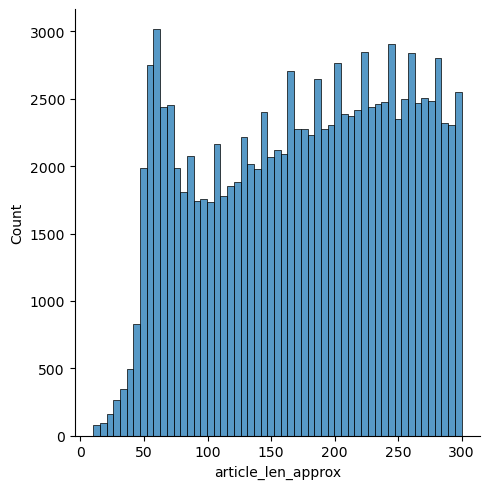

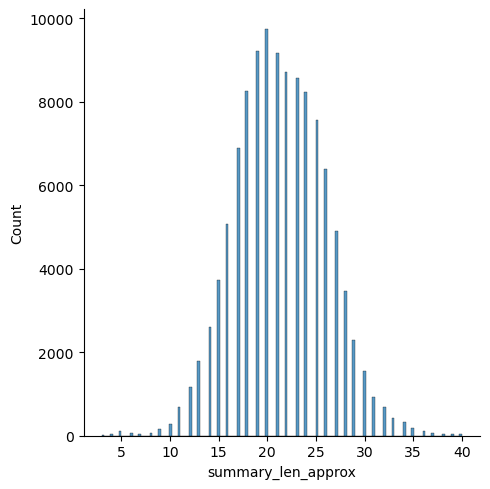

In [11]:
# Newssum combined
print('News sum available datasets:', news_sum_combined.groupby('Dataset')['Dataset'].count())

xsum_raw = news_sum_combined[ news_sum_combined['Dataset'] == 'XSum' ]

print('Preparing xsum ...')
df_xsum = preprocessor.preprocess_frame(
    xsum_raw.rename({"Content": "article", "Summary": "summary"}, axis=1).reset_index(drop=True),
    (10, 300),
    (3, 40)
)
print(df_xsum.describe())
df_xsum

## Assemble final train, validation and test sets

In [12]:
#  drop articles with only one member of length category, this will allow stratified split
def ensure_min_summary_length_group_size(df: pd.DataFrame):
    df = df[df.groupby('article_len_approx').summary_len_approx.transform('count') > 1]
    return df

# Stratified split into train, validation, test by article length
def stratified_triple_split_by_summary(df: pd.DataFrame, test_size=0.1, val_size=0.1):
    df_trainval, df_test = train_test_split(df, test_size=test_size, stratify=df['article_len_approx'])
    df_trainval.shape, df_test.shape

    # split train+val to train and validation,
    # relative original full set with test set is 1.1 so we multiply the ratio to get ~|test|

    df_train, df_val = train_test_split(df_trainval, test_size=val_size * (1 + test_size), stratify=df_trainval['article_len_approx'])

    return df_train, df_val, df_test

def save_dataset(name: str, test_size: int, val_size: int, frame: int):
    
    print('Saving dataset ' + name)
    
    frame = frame[['article', 'summary', 'article_len_approx', 'summary_len_approx']].reset_index(drop=True)
    
    train, val, test = df_train, df_val, df_test = stratified_triple_split_by_summary(
        ensure_min_summary_length_group_size(frame),
        test_size=test_size,
        val_size=val_size
    )
    
    print(f"Train:      {train.shape} - {1 - test_size - val_size}")
    print(f"Validation: {val.shape} - {val_size}")
    print(f"Test:       {test.shape} - {test_size}")
    
    train.to_csv(name + '_train.csv')
    val.to_csv(name + '_val.csv')
    test.to_csv(name + '_test.csv')
    
    print('Split and saved dataset ' + name)
    

In [13]:
# save 
save_dataset('inshorts_nodot_10-70_3-16', 0.1, 0.1, df_inshorts)

Saving dataset inshorts_nodot_10-70_3-16
Train:      (44131, 4) - 0.8
Validation: (5455, 4) - 0.1
Test:       (5510, 4) - 0.1
Split and saved dataset inshorts_nodot_10-70_3-16


In [14]:
save_dataset('xsum_nodot_10-300_3-40', 0.1, 0.1, df_xsum)

Saving dataset xsum_nodot_10-300_3-40
Train:      (90929, 4) - 0.8
Validation: (11239, 4) - 0.1
Test:       (11353, 4) - 0.1
Split and saved dataset xsum_nodot_10-300_3-40


**DONE**

In [15]:
!ls

__notebook__.ipynb		     xsum_nodot_10-300_3-40_test.csv
inshorts_nodot_10-70_3-16_test.csv   xsum_nodot_10-300_3-40_train.csv
inshorts_nodot_10-70_3-16_train.csv  xsum_nodot_10-300_3-40_val.csv
inshorts_nodot_10-70_3-16_val.csv
